### Imports

In [101]:
import cupy as cp
import pandas as pd
import numpy as np
from market_gpu import Market, save_model, read_model, plot_market, plot_traders
import matplotlib.pyplot as plt
#plt.style.use('Solarize_Light2')
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Market GPU

In [ ]:
## Learning to predict binary dividend

strats_per_agent = 50
len_agents_k = 50
len_signals = 121
#action_ratio = 0.025
action_ratio = 0.05

m = Market(len_agents=len_agents_k, dividend_mode='binary')
m.ignore_agents = cp.arange(len_agents_k)
for _ in range(500):
    m.simulate_k_step()
    i, a = np.where(m.strat_strengths[m.ignore_agents, :] < 0.1)
    m.strats[i, a] = cp.random.choice(
        [1, 0, -1],
        size=(len(i), len_signals),
        p=[action_ratio, 1-2*action_ratio, action_ratio]
    )

    m.actions[i, a] = cp.random.choice(
        [1, -1],
        size=(len(i))
    )

## Analysis

In [130]:
m = Market(len_agents=2000, strats_per_agent=50)

In [149]:
m.simulate_k_step(500)

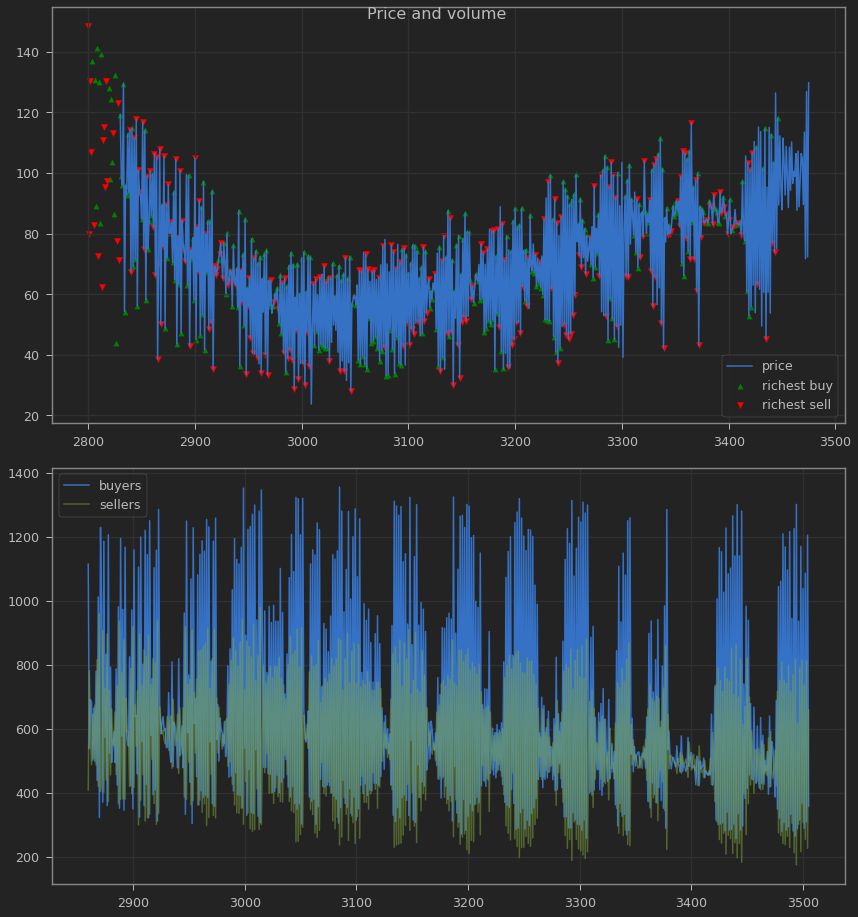

In [152]:
plot_market(m,from_index=2800,to_index=3446,richest_alpha=1)

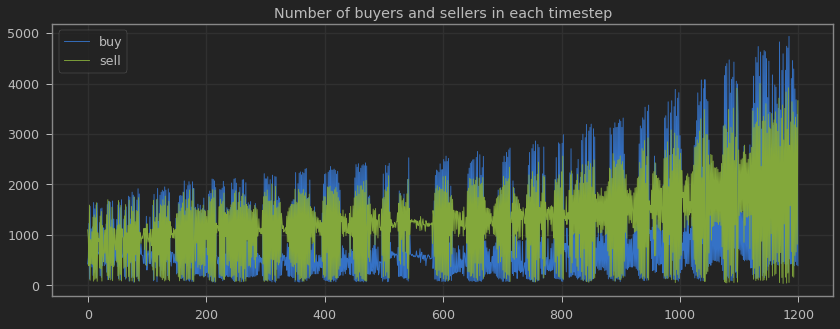

In [154]:
plt.figure(figsize=(14, 5))
plt.plot(m.buy_strs[2800:10000], label='buy', linewidth=.9)
plt.plot(m.sell_strs[2800:10000], label='sell', linewidth=.9)
plt.legend(loc='best')
plt.title('Number of buyers and sellers in each timestep');

## Generative state of the market

### Trying to squeeze out information on what signal is on what index. Broken

In [ ]:
means[:-1]/means[1:]

In [ ]:
from market_gpu import create_n_mat

a = np.vstack([(np.array(m.price_history.get())[-m.k2:])]*(m.k2-1)).T
a2 = np.vstack([(np.array(m.volume_history.get())[-m.k2:])]*(m.k2-1)).T
b = np.ma.array(a, mask=create_n_mat(m.k2))[:, ::m.d]  # price_history
c = np.ma.array(a2, mask=create_n_mat(m.k2))[:, ::m.d]  # vol_history
means = np.ma.mean(b, axis=0).data
stdevs = np.ma.std(b, axis=0).data
volmeans = np.ma.mean(c, axis=0).data
mean_signals = np.greater(
    np.vstack([means]*m.k),
    (np.linspace(0.5, 1.5, m.k)*m.price)[:, None]
).flatten('F')
stdev_signals = np.greater(
    np.vstack([stdevs]*m.k),
    (np.linspace(0.001, 1, m.k)*m.price)[:, None]
).flatten('F')
meanvol_signals = np.greater(
    np.vstack([volmeans]*m.k),
    (np.linspace(1, 50, m.k))[:, None]
).flatten('F')
fvals = m.price > np.round(np.linspace(0.25, 4.25, 8), 1)*m.fundamental_value()
rel_means = means[:-1]/means[1:]
#         m.market_state_history.append(m.market_state.get())
m.market_state = cp.array(
    np.r_[mean_signals, stdev_signals, meanvol_signals, fvals, rel_means])

np.vstack([means]*m.k), (np.linspace(0.5, 1.5, m.k)*m.price)[:, None]

### Is current market state bullish or bearish?
Let us look at the best performing 50 strats on buy and sell side. Let us sort them so similar strats would be next to each other and plot them. Also see how close the current market state is to the average of best strats. Let this note the faith in the market being bullish or bearish.

In [ ]:
# buys
ia, ist = np.where(m.actions.get() == 1)

strat_strengths = m.strat_strengths[ia, ist].get()
strats = m.strats[ia, ist].get()

i = np.unravel_index(
    strat_strengths.flatten().argsort()[-50:],
    strat_strengths.shape
)

a = strats[i]

# a.sort(axis=0)

plt.figure(figsize=(20, 5))
plt.imshow(a[~np.all(a == 0, axis=1)])

In [ ]:
plt.imshow(a[~np.all(a == 0, axis=1)].sum(axis=0)[:, None].T)

In [ ]:
# Let this be weights
b = np.maximum(1, np.abs(a[~np.all(a == 0, axis=1)].sum(axis=0)))

np.sum(
    (b/b.max()) *
    (
        m.market_state.get() -
        (1.*(a[~np.all(a == 0, axis=1)].sum(axis=0) > 0) -
         (a[~np.all(a == 0, axis=1)].sum(axis=0) < 0))
    )
)

In [ ]:
# sells
ia, ist = np.where(m.actions.get() == -1)

strat_strengths = m.strat_strengths[ia, ist].get()
strats = m.strats[ia, ist].get()

i = np.unravel_index(
    strat_strengths.flatten().argsort()[-50:],
    strat_strengths.shape
)

a = strats[i]

a.sort(axis=0)

plt.figure(figsize=(20, 5))
plt.imshow(a[~np.all(a == 0, axis=1)])

In [ ]:
# Let this be weights
b = np.maximum(1, np.abs(a[~np.all(a == 0, axis=1)].sum(axis=0)))

np.sum(
    (b/b.max()) *
    (
        m.market_state.get() -
        (1.*(a[~np.all(a == 0, axis=1)].sum(axis=0) > 0) -
         (a[~np.all(a == 0, axis=1)].sum(axis=0) < 0))
    )
)

### Use best strats to be a "template" of a new strategy

Use some weighted bias towards being more "best strategy"-like. Then replay situations in agent's own "brain" and then discriminate against new strategies. This assumes that agent tends to own strategies that show a full picture of the market, I think, but I hope not.

Also we would need to separate agents that "think" and agents that don't to compare the effect.

## Generalising strats

In [ ]:
agent_indeces = cp.arange(m.len_agents)
strat_indeces = m.strat_strengths.argmin(axis=1)
cdf = cp.where(m.strats[agent_indeces, strat_indeces] != 0)
cdf = cp.array([cdf[0], cdf[1]]).T  # ,columns=['strat_ind','strat_cond'])
cp.random.shuffle(cdf)
cdf = cdf[(cdf[:, 0]).argsort()]
si, sb = cdf.T
change_strats = cp.abs(m.strats[agent_indeces, strat_indeces][si]).sum(axis=1)
inv_bools = change_strats < cp.random.choice(
    np.arange(10, 20), size=change_strats.shape[0])
a, b = si[inv_bools], sb[inv_bools]
a2, b2 = si[~inv_bools], sb[~inv_bools]
ag, st = np.where(m.strat_strengths < -0.25)
# m.actions[ag,st] *= -1 #invert superweak strat
# m.strat_strengths[ag,st] *= -1
# m.strats[agent_indeces[a],strat_indeces[b]] *= -1 #mutate
# m.strats[agent_indeces[a2],strat_indeces[b2]] *= 0 #generalise

In [ ]:
a

## TODO:

- Dividend as searched function and stability of the result depending on number of agents
- High level communication?
- More continuous signals as market state?
- More stocks?

- Zipfs law implementation? Richest people "reach out" to more other agents. If this fails, then the way to calculate distance has been wrong and needs to be mutated.

## Agents to have different trading frequencies?

Choose some random weights for each agent that determine the trading probability distribution.

In [ ]:
m.strats.shape

In [ ]:
m.

In [ ]:
a = m.strats.get()
s = m.strat_strengths.get()
s = s-s.mean()

In [ ]:
plt.imshow(a[0])

In [ ]:
b = np.sort(a[0], axis=0)

In [ ]:
b.shape

In [ ]:
b[:, 3]

In [ ]:
plt.imshow(np.sort(a[0], axis=0))

In [ ]:
s.shape

In [ ]:
im = s[0][:, None]*a[0]
for i in range(1, s.shape[0]):
    im += s[i][:, None]*a[i]*0.1

In [ ]:
plt.imshow(im)

In [ ]:
plt.imshow(np.sort(im, axis=0))

## Communication between agents

Groups with 10 agents each communicate their action with their conviction (strength). Discriminate internally against weak decisions. Learnable distance between market states?